# EEG Power at Physiological Signal Peaks

## Find Joint Resp/EOG/EMG Peaks

In [1]:
# misc directory is at the same level as scan directory, 
# so we need to change the current working directory to the root directory
# ONLY RUN THIS CELL ONCE

import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
from scan.io.load import DatasetLoad
from scan.model.avg import EventFinder

# initialize dataset loader
loader = DatasetLoad(
    'vanderbilt'
)
# initialize dictionary to store joint peaks
subj_ses_peaks = {}
# iterate over subjects and sessions to find joint peaks
for subj, ses in loader.iter:
    data, _= loader.load_scan(
        subj, ses, 
        data='physio',
        physio_high_pass=True,
        norm='zscore'
    )
    # get average of emg and eog channels
    eog = [
        data['physio']['eog1_amp'],
        data['physio']['eog2_amp']
    ]
    eog_mean = np.mean(np.hstack(eog), axis=1)[:,np.newaxis]
    emg = [
        data['physio']['emg1_amp'],
        data['physio']['emg2_amp'],
        data['physio']['emg3_amp']
    ]
    emg_mean = np.mean(np.hstack(emg), axis=1)[:,np.newaxis]
    # find joint peaks of resp, eog, and emg amplitudes
    event_finder = EventFinder(
        height=1,
        distance=10,
        co_localization_tolerance=1,
    )
    events = event_finder.find_events(
        signals={
            'resp_amp': np.squeeze(data['physio']['resp_amp']), 
            'eog_mean': np.squeeze(eog_mean),
            'emg_mean': np.squeeze(emg_mean),
        }
    )
    joint_events = event_finder.get_joint_events(
        signal_names=['resp_amp', 'eog_mean', 'emg_mean'],
        events=events.events,
        tolerance=1
    )
    subj_ses_peaks[subj, ses] = joint_events



/Users/taylorbolt/opt/miniconda3/envs/scan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Process EEG Datasets

No events found for subject 20, session 01. Skipping...


/var/folders/1h/7cb3drr10dz9ct35lt0qyds00000gn/T/ipykernel_87630/3979991811.py:64: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  eeg_raw.set_annotations(event_annot)


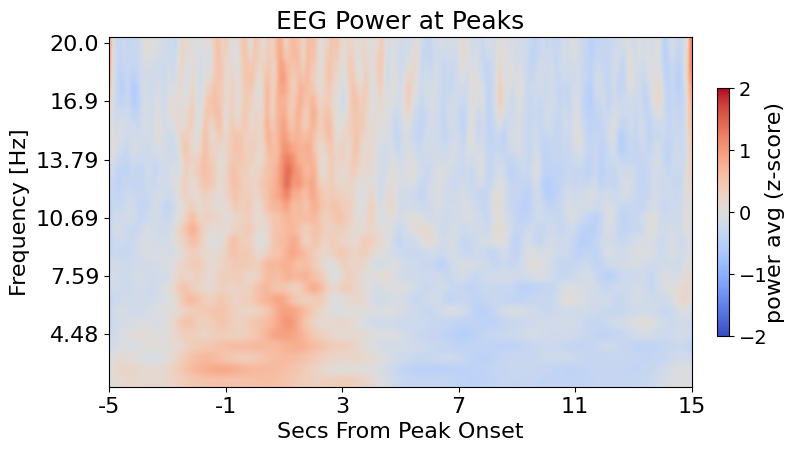

In [3]:
%matplotlib inline
import json

import matplotlib.pyplot as plt
import mne
import pandas as pd

from mne.time_frequency import tfr_morlet
from scipy.io import loadmat

from scan.preprocess.pipeline import FileMapper
from scan.preprocess.dataset import VANDERBILT_EEG_CHAN_LABELS

# set event duration of 'peak' in seconds
EVENT_DUR = 20

# shift left peaks by 5 seconds to capture pre-peak activity
SHIFT_LEFT = 5

# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20,30)

# load parameters for vanderbilt dataset
with open('scan/meta/params.json', 'rb') as f:
    params = json.load(f)['vanderbilt']

# get file paths to .mat eeg data
file_mapper = FileMapper(
    dataset='vanderbilt',
    params=params
)
file_paths = file_mapper.map()

# initialize dictionary to store power data
subj_ses_power = []

# iterate over subjects and sessions, load .mat eeg data
for subj, ses in loader.iter:
    # load .mat eeg data
    eeg_mat = loadmat(file_paths['physio'][subj][ses]['raw']['eeg'], squeeze_me=True)
    # extract eeg data and sampling frequency
    eeg_data = eeg_mat['EEG']['data'].item()
    sf_eeg = eeg_mat['EEG']['srate'].item()
    chan_labels = [chan[0] for chan in eeg_mat['EEG']['chanlocs'].item()]
    # extract indices of vanderbilt channels
    eeg_chan_idx = [chan_labels.index(chan) for chan in VANDERBILT_EEG_CHAN_LABELS]
    # extract eeg data for vanderbilt channels
    eeg_data = eeg_data[eeg_chan_idx, :]
    # create mne raw object
    info = mne.create_info(
        VANDERBILT_EEG_CHAN_LABELS, ch_types='eeg', sfreq=sf_eeg
    )
    eeg_raw = mne.io.RawArray(eeg_data, info, verbose=False)
    # resample to 100 Hz
    eeg_raw.resample(100)
    # trim off 14.7s to match trim of functional data
    eeg_raw.crop(tmin=14.7)
    # get joint peaks of resp, eog, and emg amplitudes
    peaks = subj_ses_peaks[subj, ses]
    # get first onset of joint peaks in seconds
    peaks = [(p[0] * params['func']['tr']) - SHIFT_LEFT for p in peaks]
    # Annotate raw MNE obj
    event_annot = mne.Annotations(onset=peaks, duration=EVENT_DUR, description='PEAK')
    eeg_raw.set_annotations(event_annot)
    events_mne, event_annot = mne.events_from_annotations(eeg_raw, verbose=False)
    # check if there are any events
    if len(events_mne) == 0:
        print(f'No events found for subject {subj}, session {ses}. Skipping...')
        continue
    epochs = mne.Epochs(
        eeg_raw, events_mne, 1, 0, EVENT_DUR, 
        baseline = None, verbose=False
    )
    n_cycles = 15 # number of cycles parameter for wavelet
    # Morlet wavelet evoked power average
    power_avg = epochs.compute_tfr(
        method='morlet',
        freqs=freqs,
        n_cycles=n_cycles,
        return_itc=False,
        average=True,
        verbose=False
    )
    ch_names = power_avg.ch_names
    # z-score power time courses
    power_avg.apply_baseline(baseline=(None, None), mode='zscore', verbose=False)
    # Convert to Pandas dataframe for further processing
    power_df = power_avg.to_data_frame(index=None)
    power_df['avg_chan'] = power_df[ch_names].mean(axis=1)
    power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
    power_df['subj'] = f'{subj}_{ses}'
    # store power data
    subj_ses_power.append(
        power_df[['subj', 'time','freq','freq_indx', 'avg_chan']].copy()
    )

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(subj_ses_power, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('EEG Power at Peaks', fontsize=18)
im = ax.imshow(power_group_avg[::-1, :], aspect=40,  cmap='coolwarm', 
               vmin=-2, vmax=2)
times = power_avg.times - SHIFT_LEFT
t_sample = np.arange(0, len(times), 400)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample].astype('int'))
ax.set_xlabel('Secs From Peak Onset', fontsize=16)

freq_sample = np.arange(0,len(freqs),5)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('power avg (z-score)', fontsize=16, labelpad=-2)
